In [ ]:
import sklearn
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import cv2
import os
from time import time

In [ ]:
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
letter_number = {}
cont = 0
for letter in letters:
    letter_number[letter] = cont
    cont += 1
    
# el 9(J) y el 25(Z) están cogidos
# aunque no van a aparecer nunca voy a dejarlos con su neurona
# por lo que ahora tendré que poner 3 neuronas más de salida:
# la de la Z (aunque no se use, como la de J), la de SPACE y la de STOP
letter_number["_SPACE"] = 26
letter_number["_STOP"] = 27

letters_list = []
for letra in letters:
    letters_list.append(letra)
letters_list.append("_SPACE")
letters_list.append("_STOP")


number_letter = {}
for gakoa in letter_number:
    number_letter[letter_number.get(gakoa)] = gakoa

## In the following block, the used model is loaded. Depending on the folder where it has been placed, it may be necessary to change the path.

## En el siguiente bloque se carga el modelo utilizado, depende de la carpeta en la que se ha colocado es necesario cambiar el enlace

In [ ]:
model = tf.keras.models.load_model("final_model.h5")

### All the samples used to train the model have been collected by the same person. Therefore, even though the model is capable of detecting symbols in different orientations, sizes, illuminations, and locations, the hand posture is always the same for each symbol.

### This means that the model may not be able to correctly detect a symbol, for example, if the hand is completely rotated (e.g., with the letter B symbol) or if it is pointed in the opposite direction (e.g., with the letter C symbol). This is because the model has been trained only with one posture.

### The postures used can be observed in the first image, while the second image shows two examples demonstrating how the hand should be oriented.

### Todas las muestras con las que se ha entrenado el modelo han sido recogidas por la misma persona, por lo que, a pesar de que es capaz de detectar símbolos en diferentes orientaciones, tamaños, iluminaciones y ubicaciones, la postura de la mano siempre es la misma con cada símbolo.

### Esto significa que puede que el modelo no sea capaz de detectar correctamente un símbolo, por ejemplo, si se gira completamente la mano (por ejemplo con el símbolo de la letra B), o si se apunta en la dirección contraria (por ejemplo con el símbolo de la letra C). Esto es porque el modelo se ha entrenado solamente con una postura.

### Las posturas utilizadas pueden observarse en la primera imagen, mientras que en la segunda imagen se pueden ver dos ejemplos mostrando como se debe orientar la mano.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

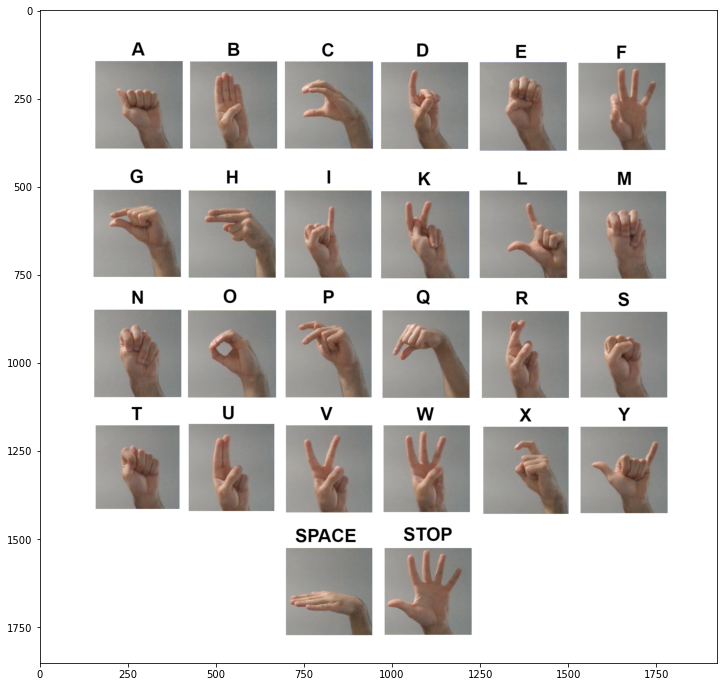

In [2]:
img = mpimg.imread("all_signs.png")
plt.figure(figsize = (15, 12))
plt.imshow(img)

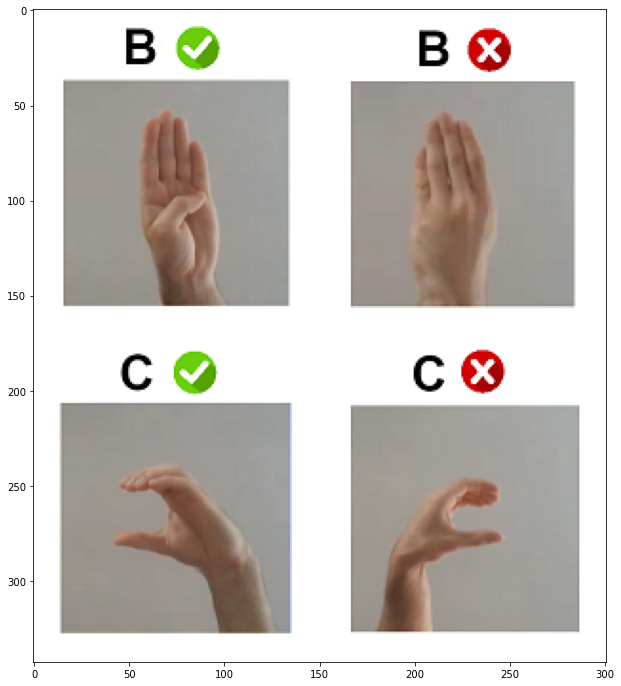

In [3]:
img = mpimg.imread("B_y_C_bien_y_mal.png")
plt.figure(figsize = (15, 12))
plt.imshow(img)

### The following two blocks are functions used by the third block.

### When executing the last block, three new screens appear, capturing the computer's camera feed in three different modes. One screen shows everything captured, with a blue square; another screen only shows what is inside the blue square, and a third screen is a small display that shows the content inside the blue square after resizing it and converting the color to grayscale.

### To start the program, it is necessary to select the screen that captures the entire image, titled 'Copy', and then hold down the 2 key on the keyboard (sometimes it takes a little while to respond). The process stops when the model predicts the stop symbol.

### A symbol is generated if the stop symbol is continuously predicted 12 times. A prediction is made every 0.2 seconds. These two heuristic criteria can be changed by modifying the values in the last block. The location of these values will be indicated through comments.

### To exit the screens, simply hold down the 1 key or the q key.

### In the white square that appears when the writing process starts, you can see the message being written at each moment, and it will remain there after finishing. If the process is started again by holding down the 2 key, the previously written content will be cleared.

### Los siguientes dos bloques son funciones que utiliza el tercero.

### Al ejecutar el último bloque aparecen 3 nuevas pantallas que captan la cámara del ordenador en tres modos distintos (una dónde se ve todo lo que capta, con un cuadrado azul; otra dónde solo se ve lo que está dentro del cuadrado azul y una última muy pequeña que enseña lo captado dentro del bloque azul después de reducir su tamaño y convertir el color a escala de grises).

### Para poner en marcha el programa es necesario seleccionar la pantalla que capta toda la imágen, la titulada como 'Copy', y después mantener pulsado el botón 2 del teclado (a veces le cuesta un poco). El proceso se detiene cuando el modelo predice el símbolo de parada.

### Se genera un símbolo si se predice continuamente 12. Y se realiza una predicción cada 0.2segundos. Es posible cambiar estos dos criterios heurísticos cambiando los valores en el último bloque. Se enseñará mediante comentarios la ubicación de estos valores.

### Para salir de las pantallas basta con mantener pulsado la tecla 1 o la tecla q.

### En el cuadrado blanco que aparecerá cuando inicie el proceso de escritura se podrá ver el mensaje escrito en cada momento, y al finalizar se quedará ahí. Si se inicia de nuevo el proceso manteniendo el botón 2 se borrará lo que estaba escrito.

In [ ]:
def prediccion_y_confianza(imagen):
    
    # preprocesado con la imagen original
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen = cv2.resize(imagen, (56, 56), interpolation = cv2.INTER_AREA)
    
    # preparación para predecir la imagen
    imagen = imagen.reshape(1, 56, 56, 1)
    imagen = imagen / 255
    
    # prediccion y confianza
    valores = model.predict(imagen)
    i_pred = np.argmax(valores[0])
    confianza = valores[0][i_pred]
    confianza = confianza * 100
    prediccion = number_letter[i_pred]
    
    return prediccion, confianza

In [ ]:
def add_text(pred, text):
        
    letra = str(pred)
    
    space_cont = 0
    
    new_text = text.copy()
    
    last_line_len = len(new_text[-1])
              
    if letra == "_SPACE":     
        if  last_line_len > 16:
            new_text.append("")
            return new_text
        else:
            new_text[-1] = new_text[-1] + "_"
            return new_text
        
    else:   
        
        if  last_line_len > 19:
            last_line_list = new_text[-1].split(" ")
            
            if len(last_line_list) == 1:
                last_line1 = last_line_list[0][: 19] + "-"
                last_line2 = last_line_list[0][19 :]
                new_text[-1] = last_line1
                new_text.append(last_line2)
                
            else:
                new_line = ""
                for line in last_line_list[: -1]:
                    new_line = new_line + " " + line
                new_text[-1] = new_line
                new_text.append(last_line_list[-1])
        
        for i in range(1, 1000):
            if len(new_text[-1]) == 0: break
            elif new_text[-1][-i] == "_": space_cont += 1
            else: break
                        
        if space_cont == 0:
            new_text[-1] = new_text[-1] + str(pred)
            return new_text
        else:
            new_text[-1] = new_text[-1][0 : -space_cont] + " "
            new_text[-1] = new_text[-1] + str(pred)
            return new_text

In [ ]:
cap = cv2.VideoCapture(0)

t = time()
empieza = False

first = True

old_pred = None
rep = 0

text = [""]
delete_text = True

while cap.isOpened():
    
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    
    roi = frame[100 : 400, 320 : 620]

    copy = frame.copy()
    cv2.rectangle(copy, (320, 100), (620, 400), (255, 0, 0), 5)

    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
    if cv2.waitKey(1) & 0xFF == ord("1"):
        break
        
    if cv2.waitKey(1) & 0xFF == ord("2"): empieza = True
    
    if not first:
        cv2.rectangle(copy, (250, 400), (700, 480), (255, 255, 255), -1)
        
        if len(text) == 1:
            print(text)
            cv2.putText(copy, text[0], (300, 450), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
        elif len(text) == 2: 
            cv2.putText(copy, text[0], (300, 430), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(copy, text[1], (300, 465), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
            
        else: 
            cv2.putText(copy, text[-1], (300, 475), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(copy, text[-2], (300, 450), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
            cv2.putText(copy, text[-3], (300, 425), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0), 2)
    
    if empieza:
        if delete_text:
            text = [""]
            delete_text = False
        
        first = False
        
        if cv2.waitKey(1) & 0xFF == ord("3"): empieza = False
            
        
        
        now = time()
        dif = now - t
         
        # We can change the period between 2 predictions in the following line.    
        # Es posible cambiar el periodo entre dos predicciones cambiando el valor de la siguiente línea.   
        if dif > 0.2: 
            pred, conf = prediccion_y_confianza(roi)
            
            cv2.putText(copy, "pred: " + str(pred) + "   conf: " + str(round(conf, 2)) + "%",
                        (150, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 3)
            
            if pred == old_pred:
                
                # We can change the number of consecutive predictions needed to generate a sign in the following line.
                # Es posible cambiar el número de predicciones iguales consecutivas necesarias para generar una letra en la siguiente línea. 
                if rep == 12:
                    rep = 0
                                        
                    if str(pred) == "_STOP":
                        empieza = False
                        delete_text = True
                    else: 
                        text = add_text(str(pred), text)
                        print(text)
                    
                else: rep += 1

            else:
                rep = 0
                old_pred = pred
                
            
    else: cv2.putText(copy, "EN PAUSA", (330, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 3)
        
    cv2.imshow("ROI", roi)
    cv2.imshow("Pantalla", copy)
    
    roi_copy = roi.copy()
    gray = cv2.cvtColor(roi_copy, cv2.COLOR_BGR2GRAY)
    gray_rs = cv2.resize(gray, (28, 28), interpolation = cv2.INTER_AREA)
    cv2.imshow("Procesado", gray_rs)


cap.release()
cv2.destroyAllWindows()   